In [ ]:
import math
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline
sns.set()

In [ ]:
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)

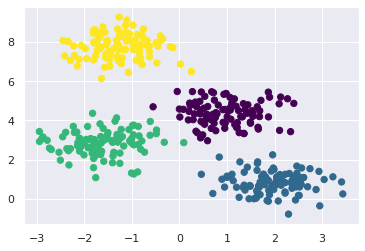

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
plt.show()

In [ ]:
class GMM:

    def __init__(self, n_features, n_components=4):
        self.n_components = n_components
        self.n_features = n_features

        self.pi = np.ones((self.n_components,)) / self.n_components
        self.mu = np.random.randn(self.n_components, self.n_features)
        self.sigma = np.array(
            [np.eye(self.n_features) for _ in range(self.n_components)])
        
        self.loss = 0

    def e_step(self, X):
        gamma = np.zeros((X.shape[0], self.n_components))
        for c in range(self.n_components):
            rv = multivariate_normal(mean=self.mu[c, :],
                                     cov=self.sigma[c, :, :])
            gamma[:, c] = rv.pdf(X) * self.pi[c]

        for i in range(X.shape[0]):
            gamma[i, :] = gamma[i, :] / gamma[i, :].sum()
        
        return gamma

    def m_step(self, X, gamma):
        n = X.shape[0]
        for c in range(self.n_components):
            q_sum = gamma[:, c].sum()
            self.pi[c] = q_sum / n
            self.mu[c, :] = gamma[:, c].T.dot(X) / q_sum
            self.sigma[c, :] = np.sum(
                [np.outer(X[i] - self.mu[c], X[i] - self.mu[c]) * \
                    gamma[i, c] for i in range(n)], axis=0) / q_sum

    def variational_lower_bound(self, X, gamma):
        log = lambda x: np.log(x + 1e-20)
        gauss = lambda x, mu, sigma: multivariate_normal(mean=mu, cov=sigma) \
                                        .pdf(x)
        loss = 0
        for i in range(X.shape[0]):
            for c in range(self.n_components):
                loss += gamma[i, c] * \
                    (np.log(self.pi[c] + 1e-20) + \
                        np.log(gauss(X[i], self.mu[c], self.sigma[c]) + 1e-20) \
                     - np.log(gamma[i, c] + 1e-20))
        return loss

    def fit(self, X, rtol=1e-3, max_iter=100, restarts=10):
        assert X.shape[1] == self.n_features, 'n_features doesnt match data shape'

        best_loss = - math.inf
        best_pi = None
        best_mu = None
        best_sigma = None

        losses = []

        for _ in range(restarts):
            try:
                last_loss = None
                for _ in range(max_iter):
                    gamma = self.e_step(X)
                    self.m_step(X, gamma)
                    loss = self.variational_lower_bound(X, gamma)
                    losses.append(loss)

                    if last_loss:
                        if abs((loss - last_loss) / last_loss) < rtol:
                            break
                    
                    if loss > best_loss:
                        best_loss = loss
                        best_pi = self.pi
                        best_mu = self.mu
                        best_sigma = self.sigma

                    last_loss = loss

            except np.linalg.LinAlgError:
                print("Singular matrix: components collapsed")
                pass

        self.loss = best_loss
        self.pi = best_pi
        self.mu = best_mu
        self.sigma = best_sigma

        GMM.plot_loss_history(losses)

    @staticmethod
    def plot_loss_history(losses):
        plt.figure(figsize=(15, 5))
        plt.plot(losses, label=f'Loss - {np.max(losses)}')
        plt.title('Loss history')
        plt.grid()
        plt.legend()
        plt.show()

    def predict(self, X):
        assert X.shape[1] == self.n_features, 'n_features doesnt match data shape'
        gamma = self.e_step(X)
        return gamma.argmax(axis=1)

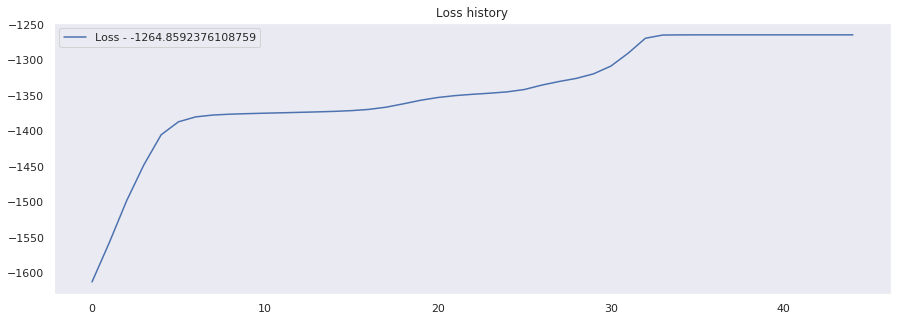

CPU times: user 13.6 s, sys: 54.5 ms, total: 13.7 s
Wall time: 13.6 s


In [ ]:
%%time
model = GMM(n_features=X.shape[1], n_components=len(np.unique(y)))
losses = model.fit(X)

In [ ]:
y_pred = model.predict(X)

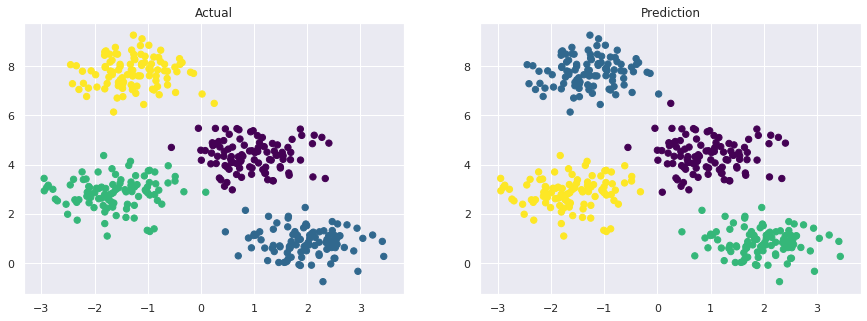

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
axes[0].set_title('Actual')
axes[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=40, cmap='viridis')
axes[1].set_title('Prediction')
plt.show()